In [39]:
import sys
import numpy
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
from scipy.ndimage import label


def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [40]:
import os
import glob
import re
import pandas as pd
from tqdm import tqdm

def to_df(mmms_folder_name, pop_parameter, verbose = False):
    # Define pattern to match values from lines
    prob_pattern_pop = r"Probability: P\(mass <= max_mass\(spin, eos\)\) = ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"
    odds_pattern_pop = r"Odds Ratio\s*:.*= ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"

    prob_pattern_np = prob_pattern_pop
    odds_pattern_np = odds_pattern_pop

    prob_pattern_eos = r"Probability: P\(.*?\) = ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"
    odds_pattern_eos = r"Odds Ratio\s*:.*?= ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"


    # Create list to hold parsed data
    data = []

    # Loop through all .out files
    glob_path = f"../{mmms_folder_name}/*.out"
    for filepath in glob.glob(glob_path):

        if re.search(r"EOS", filepath):
            prob_pattern = prob_pattern_eos
            odds_pattern = odds_pattern_eos 
        elif re.search(r"non-parametric", filepath):
            prob_pattern = prob_pattern_np
            odds_pattern = odds_pattern_np 
        else:
            prob_pattern = prob_pattern_pop
            odds_pattern = odds_pattern_pop 


        with open(filepath, "r") as f:
            content = f.read()
            prob_match = re.search(prob_pattern, content)
            odds_match = re.search(odds_pattern, content)

            if prob_match and odds_match:
                prob, prob_err = map(float, prob_match.groups())
                odds, odds_err = map(float, odds_match.groups())
                data.append({
                    "filename": filepath,
                    "probability": prob,
                    "prob_error": prob_err,
                    "odds_ratio": odds,
                    "odds_error": odds_err
                })
            else:
                if verbose:
                    print(f"Warning: Could not parse values from {filepath}")

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)
    
    # Wrangle more
    df[pop_parameter] = df["filename"].str.extract(fr"{pop_parameter}\+(-?[\d.]+)").astype(float)
    df["event"] = df["filename"].str.extract(r"(GW\d+)")
    df["component"] = df["filename"].str.extract(r"component(\d+)").astype(int)
    return df

def simple_grid_plot(df, pop_parameter):
    GW190917_m1 = df[(df['event'] == "GW190917") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190917_m2 = df[(df['event'] == "GW190917") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW230529_m1 = df[(df['event'] == "GW230529") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190814_m2 = df[(df['event'] == "GW190814") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m1 = df[(df['event'] == "GW190425") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m2 = df[(df['event'] == "GW190425") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m1 = df[(df['event'] == "GW200105") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m2 = df[(df['event'] == "GW200105") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200115_m2 = df[(df['event'] == "GW200115") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    plt.figure()
    objects_lst = [GW230529_m1, GW190814_m2, GW190917_m2, GW190917_m1, GW190425_m2, GW190425_m1, GW200105_m2, GW200105_m1, GW200115_m2]
    objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(objects_lst) - 1)) for i in range(len(objects_lst))]

    for i in range(len(objects_lst)):
        curr = objects_lst[i]
        curr_name = objects_names[i]
        p05 = curr["probability"] - curr["prob_error"] * 2
        p95 = curr["probability"] + curr["prob_error"] * 2
        if i == len(objects_lst) - 1:
            lab = "95\% CI"
        else:
            lab = None
        plt.plot(curr[pop_parameter], curr["probability"], label=curr_name, color = objects_colors[i])
        plt.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    plt.ylabel("P(NS)")
    plt.xlabel(f"{pop_parameter}")
    plt.utkarshWrapper()
    plt.show()

In [41]:
import json

with open("folder2pop_parameter.json", "r") as f:
    folder2pop_parameter = json.load(f)

In [42]:
folders = [f for f in os.listdir("../") if os.path.isdir(os.path.join("../", f)) and f.startswith("grid")]
label_lst = [f[len("grid")+1:] for f in folders]
exclude_lst = ["gamma_low_debug", "plots", "mmms_plot_gamma_low", "mu_cos_tilt_debug", "mmms_plot_beta_low"]


df_lst = []

for label in tqdm(label_lst):
    if label in exclude_lst:
        df = pd.DataFrame()
        df_lst.append(df)
        continue

    pop_parameter = folder2pop_parameter[label]

    df = to_df(f"grid_{label}", pop_parameter)

    # Check if pop_parameter column exists
    if pop_parameter not in df.columns:
        print(f"[ERROR] Dataframe with {label} is missing the column '{pop_parameter}'")
        display(df)
        break

    # Ensure dataframe does not have None's in them
    # Check if any item in the DataFrame is None
    has_none = (df.isnull().values.any() or (df == None).values.any())
    if has_none:
        print(f"[ERROR] Dataframe with {label} has None values in it")
        display(df)
        break

    df_lst.append(df)
    pop_parameter = None

results = dict(zip(label_lst, df_lst))

results_serializable = {k: v.to_dict(orient="list") for k, v in results.items()}
with open("results.json", "w") as f:
    json.dump(results_serializable, f, indent=2)

100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


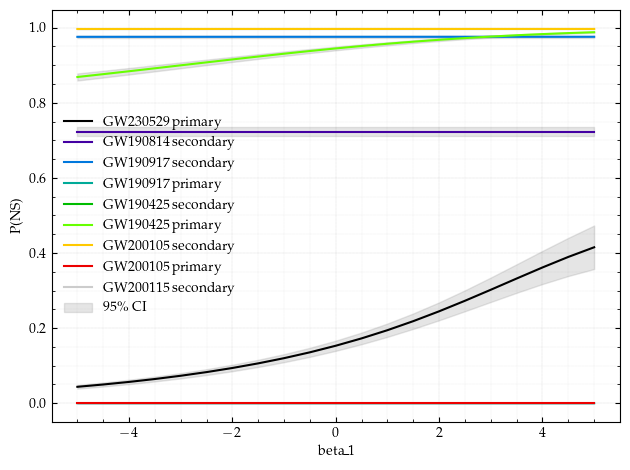

In [44]:
item = "beta_low_NS"
simple_grid_plot(results[item], folder2pop_parameter[item])